In [440]:
%aiida

** Note! AiiDA DB environment already loaded! I do not reload it again.

In [441]:
import os
import numpy as np

from ipywidgets import interact

In [442]:
from aiida.orm import Code, DataFactory, CalculationFactory
from aiida.orm.data.base import Float, Str

SiestaCalculation = CalculationFactory('siesta.siesta')
PsfData = DataFactory('siesta.psf')
StructureData = DataFactory('structure')
ParameterData = DataFactory('parameter')
KpointsData = DataFactory('array.kpoints')

In [443]:
code = None
def select_code(codename):
    global code
    code = Code.get_from_string(codename)

code_choice = interact(select_code, 
                       codename=Code.list_for_plugin('siesta.siesta'))

interactive(children=(Dropdown(description=u'codename', options=(u'siesta-m',), value=u'siesta-m'), Output()), _dom_classes=('widget-interact',))

In [444]:
filter_elements=("Sr", "Ti", "O")

In [445]:
pseudo_family = None
def select_pseudo_family(family):
    global pseudo_family
    pseudo_family = family
    
pseudo_family_choice = interact(select_pseudo_family,
                                family=PsfData.get_psf_groups(filter_elements=filter_elements))

interactive(children=(Dropdown(description=u'family', options=(<Group: "another_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>, <Group: "example_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>), value=<Group: "another_family" [type data.psf.family], of user vladimir.dikan@icn2.cat>), Output()), _dom_classes=('widget-interact',))

In [446]:
inputs = SiestaCalculation.process().get_inputs_template()
inputs.code = code
inputs._options.resources = {
    "num_machines": 1,
    "num_mpiprocs_per_machine": 1,
}
inputs._options.max_wallclock_seconds = 30 * 60

In [447]:
alat = 3.874

lvecs = np.array([ 1.0,
                   1.0,
                   1.0,]) * alat

cell = np.array([[1.0, 0.0, 0.0,],
                 [0.0, 1.0, 0.0,],
                 [0.0, 0.0, 1.0,],])

cell = np.multiply(cell, lvecs)

In [448]:
structure = StructureData(cell=cell)  # Creating structure from cell 
# Placing basis atoms
structure.append_atom(position=(0.0 * alat, 0.0 * alat, 0.0 * alat),
                      symbols=['Sr'])
structure.append_atom(position=(0.5 * alat, 0.5 * alat, 0.5 * alat),
                      symbols=['Ti'])
structure.append_atom(position=(0.5 * alat, 0.5 * alat, 0.0 * alat),
                      symbols=['O'])
structure.append_atom(position=(0.5 * alat, 0.0 * alat, 0.5 * alat),
                      symbols=['O'])
structure.append_atom(position=(0.0 * alat, 0.5 * alat, 0.5 * alat),
                      symbols=['O'])

inputs.structure = structure

In [449]:
# Pseudopotentials
from aiida_siesta.data.psf import get_pseudos_from_structure

inputs.pseudo = get_pseudos_from_structure(structure, pseudo_family.name)

In [450]:
# K-points mesh
kpoints_mesh = KpointsData()
kpoints_mesh.set_kpoints_mesh([6, 6, 6], [0.5, 0.5, 0.5])

inputs.kpoints = kpoints_mesh

In [451]:
# Bands' k-points
bandskpoints = KpointsData()
bandskpoints.set_cell(structure.cell, structure.pbc)
bandskpoints.set_kpoints_path([
    ('G', 'X', 21),
    ('X', 'M', 21),
    ('M', 'G', 21),
    ('G', 'R', 21),
    ('R', 'X', 21),
])

inputs.bandskpoints = bandskpoints

In [452]:
block_ps_lmax_content = """
   Sr    3
   Ti    3
    O    3
"""


In [453]:
block_pao_basis_content = """
Sr   5      1.64000
 n=4   0   1   E   155.00000     6.00000
     6.49993
     1.00000
 n=5   0   2   E   149.48000     6.50000
     6.99958     5.49957
     1.00000     1.00000
 n=4   1   1   E   148.98000     5.61000
     6.74964
     1.00000
 n=5   1   1   E     4.57000     1.20000
     4.00000
     1.00000
 n=4   2   1   E   146.26000     6.09000
     6.63062
     1.00000
Ti    5      1.91
 n=3    0    1   E     93.95      5.20
   5.69946662616249
   1.00000000000000
 n=3    1    1   E     95.47      5.20
   5.69941339465994
   1.00000000000000
 n=4    0    2   E     96.47      5.60
   6.09996398975307        5.09944363262274
   1.00000000000000        1.00000000000000
 n=3    2    2   E     46.05      4.95
   5.94327035784617        4.70009988294302
   1.00000000000000        1.00000000000000
 n=4    1    1   E      0.50      1.77
   3.05365979938936
   1.00000000000000
O     3     -0.28
 n=2    0    2   E     40.58      3.95
   4.95272270428712        3.60331408800389
   1.00000000000000        1.00000000000000
 n=2    1    2   E     36.78      4.35
   4.99990228025066        3.89745395068600
   1.00000000000000        1.00000000000000
 n=3    2    1   E     21.69      0.93
   2.73276990670788
   1.00000000000000
"""

In [454]:
block_pdos_content = """
  -70.00  5.00  0.150 3000  eV
"""


In [455]:
block_pdos_kgrid_content = """
   60  0  0  0.5
    0 60  0  0.5
    0  0 60  0.5
%end PDOS-kgrid_Monkhorst_Pack
"""

In [456]:
# Hack: need non-empty `settings` to retreive pdos.xml 
settings = ParameterData(dict={'flagpdos': True})
inputs.settings = settings

In [457]:
# Calculation parameters
parameters  = ParameterData(dict={
    'xc-functional': 'LDA',
    'xc-authors': 'CA',
    'spin-polarized': False,
    'meshcutoff': '400 Ry',
    'max-scfiterations': 300,
    'dm-numberpulay': 3,
    'dm-mixingweight': 0.2,
    'dm-tolerance': 0.0001,
    'electronictemperature': '0.075 eV',
    'scf-mixafterconvergence': False,
    'dm-usesavedm': False,
    '%block ps-lmax': block_ps_lmax_content,
    '%block pao-basis': block_pao_basis_content,
    '%block projecteddensityofstates': block_pdos_content,
    '%PDOS-kgrid-Monkhorst_Pack': block_pdos_kgrid_content,
})

inputs.parameters = parameters

In [458]:
! verdi daemon restart

Shutting down AiiDA Daemon (19959)...
Waiting for the AiiDA Daemon to shut down...
AiiDA Daemon shut down correctly.
Clearing all locks ...
Starting AiiDA Daemon ...
Daemon started


In [459]:
# Create and run Siesta calculation process
from aiida.work.run import run

JobCalc = SiestaCalculation.process()
result = run(JobCalc, **inputs)

In [460]:
out     = result['output_parameters'].get_dict()
bands   = result['bands_array']
bparams = result['bands_parameters'].get_dict()

pd = result['pdos_data'].get_array('data')
pi = result['pdos_info'].get_dict()

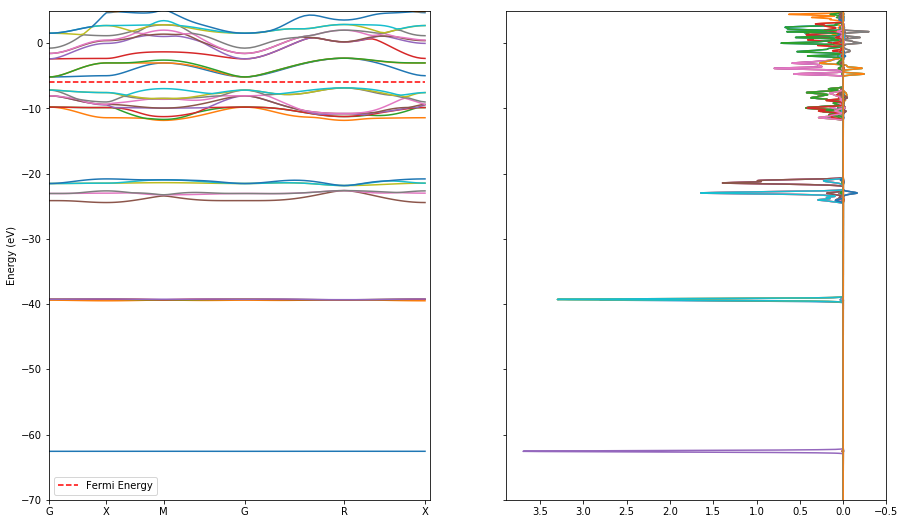

In [505]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 9.0)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Plot bands
for band in zip(*bands.get_bands()):
    ax1.plot(bparams['kp_coordinates'], band,)

# Plot E_Fermi
ax1.plot((bparams['kp_coordinates'][0], bparams['kp_coordinates'][-1]),
         (out['E_Fermi'], out['E_Fermi']),
         '--r', label="Fermi Energy")   

ticks = [(bparams['kp_coordinates'][xt], xl) 
         for xt, xl in bandskpoints.labels]
#ax1.set_xticks(zip(*ticks)[0], zip(*ticks)[1])
ax1.set_xticks(zip(*ticks)[0])
ax1.set_xticklabels(zip(*ticks)[1])
ax1.axis([0.0, 2.85, -70.0, 5.0])  # rescale
ax1.set_ylabel("Energy (eV)")
ax1.legend()

for orbital in pd:
    ax2.plot(orbital, pi['energy_values']['data'])

ax2.invert_xaxis()